# [NetworkX](https://networkx.github.io/) Tutorial 4

The official documentation for NetworkX can be found [here](https://networkx.github.io/documentation/stable/).

In this tutorial, we will explore several community detection and link prediction methods.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

First, let's create a random graph with a community structure. This can be accomplished using [stochastic_block_model](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.stochastic_block_model.html?highlight=stochastic_block_model#networkx.generators.community.stochastic_block_model), which generates a random graph based on a list of group sizes and corresponding edge probabilities that can be represented by an n-dimensional array. 

For example, if we have a network with 3 different groups {A, B, C}, we can define the edge probability matrix: 
\begin{equation}
P = \left(
\begin{array}{ccc}
0.5 & 0.3 & 0.2 \\
0.3 & 0.4 & 0.1 \\
0.2 & 0.1 & 0.7
\end{array}\right)
\end{equation}
which means an edge exists with probability $p_{aa} = 0.5$ within group A and probability $p_{ab} = 0.3$ between group A and B, etc.

Let's generate a graph $G$ with this model and take a look at its structure. We will generate a graph with 3 communities. 

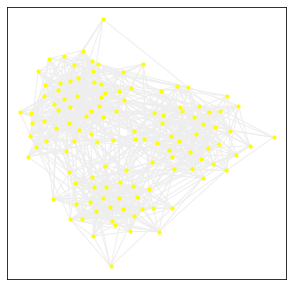

In [2]:
sizes = [50, 40, 30]
probs = [[0.25, 0.04, 0.03], [0.04, 0.3, 0.05], [0.03, 0.05, 0.40]]
G = nx.stochastic_block_model(sizes, probs, seed=0)
pos = nx.spring_layout(G)
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color='yellow', node_size=10,
                edge_color='#eeeeee', width=1)

Note that the probabilities of adding an edge within groups are 0.25, 0.3, and 0.4, while the probabilities of creating egdes across groups are much lower. Thus, we can expect $G$ to have 3 communities.

Let's see how different community detection algorithms partition our graph. 

## Girvan–Newman

We can use different community detection algorithms to find a partition. For example, we can apply the [Girvan–Newman method](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html?highlight=girvan_newman#networkx.algorithms.community.centrality.girvan_newman),
```python
networkx.algorithms.community.centrality.girvan_newman(G, most_valuable_edge=None)
```
which returns a generator that produces partitions one at a time. We can retrieve a partition with the built-in function `next()` in Python. 

Let's get the first partition produced by Girvan-Newman:

In [3]:
generator = nx.algorithms.community.centrality.girvan_newman(G)
first_partition = next(generator)
len(first_partition)

2

This partition divides the network into two groups. We can color the nodes by this partition to see the outcome. 

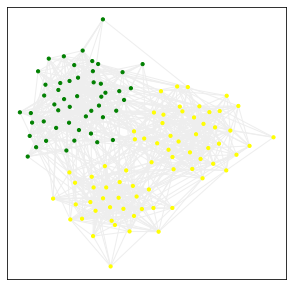

In [4]:
color_list = ['green', 'yellow']
node_color_list = [color_list[0] if i in first_partition[0] else color_list[1] for i in G.nodes]
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

This partition looks reasonable. Nevertheless, we can generate the next partition to see what a third community would look like. 

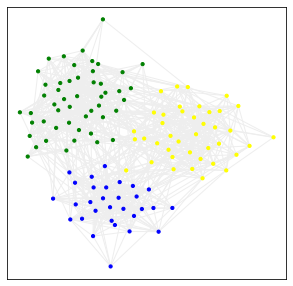

In [5]:
second_partition = next(generator)
color_list = ['green', 'yellow', 'blue']
for i, v in enumerate(G.nodes):
    if v in second_partition[0]:
        node_color_list[i] = color_list[0]
    elif v in second_partition[1]:
        node_color_list[i] = color_list[1]
    else:
        node_color_list[i] = color_list[2]

plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

This looks optimal (and it is optimal due to the network's construction). Let's see what the next partition looks like

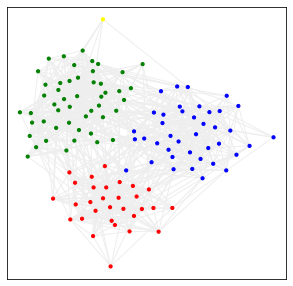

In [6]:
third_partition = next(generator)
color_list = ['green', 'yellow', 'blue', 'red']
for i, v in enumerate(G.nodes):
    if v in third_partition[0]:
        node_color_list[i] = color_list[0]
    elif v in third_partition[1]:
        node_color_list[i] = color_list[1]
    elif v in third_partition[2]:
        node_color_list[i] = color_list[2]
    else:
        node_color_list[i] = color_list[3]

plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

Clearly, partitioning the network into 4 communities rather than 3 did not generate a better partition. We will compare the modularity values at the end. 

## Clauset-Newman-Moore

While the Girvan–Newman algorithm begins with a single community and it creates partitions by removing edges with high betweenness centrality, Agglomerative Hierarchical Clustering begins with all nodes in their own community and merges pairs of communities that lead to a higher modularity score. 

The [Clauset-Newman-Moore](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html?highlight=greedy_modularity_communities#networkx.algorithms.community.modularity_max.greedy_modularity_communities) is one of such Agglomerative Hierarchical Clustering implementations. 


```python
networkx.algorithms.community.modularity_max.greedy_modularity_communities(G)
```
This method returns a list of Frozensets, which are immutable Python set objects (elements in the set cannot be modified).

In [7]:
gred_partition = nx.algorithms.community.greedy_modularity_communities(G)
len(gred_partition)

3

As you can see, the algorithm correctly identifies the number of communities. 

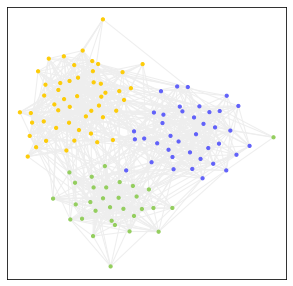

In [8]:
color_list = ['#FDCC07', '#6060FA', '#93CE5D']
for i, v in enumerate(G.nodes):
    if v in gred_partition[0]:
        node_color_list[i] = color_list[0]
    elif v in gred_partition[1]:
        node_color_list[i] = color_list[1]
    else:
        node_color_list[i] = color_list[2]

plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

## Label propagation

[label_propagation_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html?highlight=label_propagation_communities#networkx.algorithms.community.label_propagation.label_propagation_communities) generates partitions using a label propagation algorithm. This function returns a generator as well, but each time the generator yields a set of nodes in the same group. We can convert the generator to a list of sets conveniently.

In [9]:
lp_generator = nx.algorithms.community.label_propagation.label_propagation_communities(G)
lp_partition = list(lp_generator)
len(lp_partition)

3

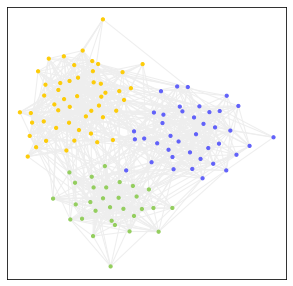

In [10]:
color_list = ['#FDCC07', '#6060FA', '#93CE5D']
for i, v in enumerate(G.nodes):
    if v in lp_partition[0]:
        node_color_list[i] = color_list[0]
    elif v in lp_partition[1]:
        node_color_list[i] = color_list[1]
    else:
        node_color_list[i] = color_list[2]

plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

## Fluid communities 

We did not cover this one in lecture. [This algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.asyn_fluid.asyn_fluidc.html#networkx.algorithms.community.asyn_fluid.asyn_fluidc) is influenced by the interactions of fluids in an environment. Initially,  𝑘  communities are assigned to  𝑘  different nodes with density 1. During each iteration, every node is assigned to the community with the maximum density shared among its neighbors. Then the density of this community is reassigned uniformly among its members. The algorithm stops when the labels of all nodes do not change in two consecutive rounds. Note that unlike the other algorithms, you must predetermine the number of communities with input parameter 𝑘. 

```python
networkx.algorithms.community.asyn_fluid.asyn_fluid(G, k[, max_iter, seed])
```

In [11]:
fluid_partition = list(nx.algorithms.community.asyn_fluidc(G, 3, max_iter=100, seed=42))
len(fluid_partition)

3

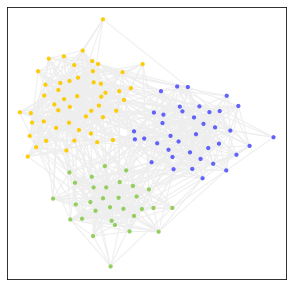

In [12]:
color_list = ['#FDCC07', '#6060FA', '#93CE5D']
for i, v in enumerate(G.nodes):
    if v in fluid_partition[0]:
        node_color_list[i] = color_list[0]
    elif v in fluid_partition[1]:
        node_color_list[i] = color_list[1]
    else:
        node_color_list[i] = color_list[2]

plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False, 
                 node_color=node_color_list, node_size=10,
                edge_color='#eeeeee', width=1)

## Evaluating a partition

In the previous sections, we introduced several community detection methods. However, how do we evaluate the quality of a partition?

[NetworkX provides a set of metrics](https://networkx.org/documentation/stable/reference/algorithms/community.html?highlight=modularity#module-networkx.algorithms.community.quality), which evaluate the goodness of a partition from different perspectives:

```python
networkx.algorithms.community.modularity(G, communities, weight='weight')
networkx.algorithms.community.quality.coverage(G, partition)
networkx.algorithms.community.quality.performance(G, partition)
```

For example, we can compute the modularity of the partition generated by the first and second iterations of the Girvan-Newman algorithm:

In [13]:
nx.algorithms.community.modularity(G, first_partition)

0.3489270053955369

In [14]:
nx.algorithms.community.modularity(G, second_partition)

0.4501625996381241

In [15]:
nx.algorithms.community.modularity(G, third_partition)

0.44725699708217187

Let's compare the coverage of the partitions generated by Girvan-Newman and Clauset-Newman-Moore:

In [16]:
nx.algorithms.community.quality.coverage(G, second_partition)

0.7972027972027972

In [17]:
nx.algorithms.community.quality.coverage(G, gred_partition)

0.7937062937062938

Let's compare the performance of partitions generated by the label propogation and fluid algorithms:

In [18]:
nx.algorithms.community.quality.performance(G, lp_partition)

0.7296918767507002

In [19]:
nx.algorithms.community.quality.performance(G, fluid_partition)

0.730672268907563

# End